<a href="https://colab.research.google.com/github/AmberG08/GOSLING_Amber_MEngCapstone/blob/master/vcc_lstm4boxcox_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
#drive.mount('/content/mnt')
#nb_path = '/content/notebooks'
#os.symlink('/content/mnt/My Drive/Capstone', nb_path)
##sys.path.insert(0, nb_path)  # or append(nb_path)

!pip install scikeras[tensorflow]
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


                Timestamp    VCC
809   2021-04-27 13:30:00   0.39
2028  2021-04-28 09:49:00   0.93
3532  2021-04-29 10:53:00   2.08
4901  2021-04-30 09:42:00   4.42
6318  2021-05-01 09:19:00   9.39
7781  2021-05-02 09:42:00  13.00
9199  2021-05-03 09:20:00  17.29
10654 2021-05-04 09:35:00  19.27
12090 2021-05-05 09:31:00  16.84
13529 2021-05-06 09:30:00  14.42
14939 2021-05-07 09:00:00  12.24


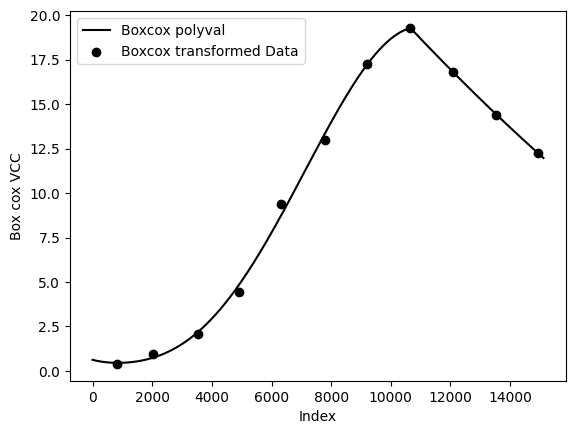

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from mapie.regression import MapieRegressor

'''Load in file'''
df_main = pd.read_csv('/content/drive/MyDrive/Capstone/CleanedData.csv')

'''Load in file'''
df_main = pd.read_csv('/content/drive/MyDrive/Capstone/CleanedData.csv')
df_main['Timestamp'] = pd.to_datetime(df_main['Timestamp'], format='%d/%m/%Y %H:%M')


'''Getting VCC datapoints'''
df_celldata = pd.DataFrame(df_main, columns=['Timestamp', 'VCC'])

no_nans = df_celldata[~df_celldata.isnull().any(axis=1)]
print(no_nans)


actuals = df_celldata['VCC']

celldata=df_celldata['VCC'].to_numpy()
celldata = celldata.reshape((len(celldata),1))

boxcox = PowerTransformer(method='box-cox')
df_celldata['VCC'] = boxcox.fit_transform(celldata)

'''Separating data'''
time_sep=pd.to_datetime('2021-05-04 9:35:00')
df_log = df_celldata[df_celldata['Timestamp'] <= time_sep]
df_death = df_celldata[df_celldata['Timestamp'] >= time_sep]

df_log = df_log['VCC']
df_death = df_death['VCC']

nan_indices_log = np.isnan(df_log)
coefficients_log = np.polyfit(df_log.index[~nan_indices_log], df_log[~nan_indices_log], 3)
df_log= np.polyval(coefficients_log, df_log.index)
#print(df_log.shape)

nan_indices_death = np.isnan(df_death)
coefficients_death = np.polyfit(df_death.index[~nan_indices_death], df_death[~nan_indices_death], 1)
df_death = np.polyval(coefficients_death, df_death.index)
#print(df_death.shape)

'''Inverse box cox transform'''

""" Concatenation """
df_log = df_log[:-1] # cut out last datapoint to make them connect
df_main['VCC'] = boxcox.inverse_transform(pd.concat([pd.DataFrame(df_log), pd.DataFrame(df_death)], axis=0, ignore_index=True))

plt.plot(df_main.index, df_main['VCC'], label='Boxcox polyval', color='black')
plt.scatter(actuals.index, actuals, label='Boxcox transformed Data', color='black')
plt.xlabel("Index")
plt.ylabel("Box cox VCC")
plt.legend()
plt.show()

'''Cut out intial data''' ##Cut out as required
cut_date_time = pd.to_datetime('2021-04-30 14:45:00')
df_main = df_main[df_main['Timestamp'] >= cut_date_time]
actuals = df_main['VCC']

# plt.plot(df_main.index, df_main['VCC'], label='Boxcox polyval', color='black')
# #plt.scatter(df_celldata.index, df_celldata['VCC'], label='Boxcox transformed Data', color='black' )
# plt.xlabel("Index")
# plt.ylabel("Box cox VCC")
# plt.legend()
# plt.show()

In [21]:
""" Set features and target """
filtered_df= df_main.drop('Timestamp', axis=1)
X_df = filtered_df#[['Pred (X) 3 PV - O2 Sparge','CEDEX - GLC3B', 'Added Volume', 'Total Volume', 'VCC']]
y_df = filtered_df[['VCC']]

from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X_df)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y_df)

X_df = X_scaler.fit_transform(X_df)
y_df = y_scaler.fit_transform(y_df)

def df_to_X_y(df, window_size):
  df_as_np = df #df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]] #[a] wraps the row in brackets
    X.append(row)
    label = df_as_np[i+window_size][14]
    y.append(label)
  return np.array(X), np.array(y)

print('Windowing Function in progress')

WINDOW_SIZE = 1
X1, y1 = df_to_X_y(X_df, WINDOW_SIZE)
#print(X1[0])
#print(y1)

print('\nWindow Function done')

# split into train and test sets
train_size = int(len(X_df) * 0.70)
test_size = len(X_df) - train_size

X_train, y_train = X1[0:train_size], y1[0:train_size]
X_test, y_test = X1[train_size:len(X_df)], y1[train_size:len(X_df)]

'''Scaling'''
#scaler = StandardScaler().fit(X_train) #Computes mean and st. dev
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)
#X_val = scaler.transform(X_val)
#print('\n', X_train)

model1 = Sequential() #This is good
model1.add(InputLayer((WINDOW_SIZE, 15))) #InputLayer((time_steps, features)
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear')) #Important

model1.summary()

'''Compiling the model'''
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

'''Mapie'''
lstm_model=KerasRegressor(build_fn=model1, epochs=10, batch_size=64) #, callbacks=[cp1])
#lstm_model.fit(X_train, y_train)
#print("\nScikeras model fitted")

mapie_regressor = MapieRegressor(estimator=lstm_model, method='plus')
mapie_regressor = mapie_regressor.fit(X_train, y_train)
print("\n Mapie model fitted")





Windowing Function in progress

Window Function done


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,009 (82.07 KB)

 Trainable params: 21,009 (82.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1151 - root_mean_squared_error: 0.3136
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6210e-04 - root_mean_squared_error: 0.0189
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5437e-04 - root_mean_squared_error: 0.0123
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7358e-05 - root_mean_squared_error: 0.0069
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2185e-05 - root_mean_squared_error: 0.0077
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1970e-05 - root_mean_squared_error: 0.0064
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0565e-05 - root_mean_squared_error: 0.0045
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5387e-05 - root_mean_squared_error: 0.0050
Epoch 10/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4100e-05 - 

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1377 - root_mean_squared_error: 0.3474
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0176e-04 - root_mean_squared_error: 0.0282
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5027e-04 - root_mean_squared_error: 0.0212
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8387e-04 - root_mean_squared_error: 0.0168
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2357e-04 - root_mean_squared_error: 0.0149
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2287e-04 - root_mean_squared_error: 0.0149
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8257e-04 - root_mean_squared_error: 0.0135
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3040e-04 - root_mean_squared_error: 0.0114
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4160e-04 - root_mean_squared_er

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1250 - root_mean_squared_error: 0.3292
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.5377e-04 - root_mean_squared_error: 0.0292
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5368e-04 - root_mean_squared_error: 0.0188
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7450e-04 - root_mean_squared_error: 0.0132
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3530e-05 - root_mean_squared_error: 0.0097
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8140e-05 - root_mean_squared_error: 0.0082
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8233e-05 - root_mean_squared_error: 0.0043
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6001e-05 - root_mean_squared_error: 0.0040
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2991e-05 - root_mean_squared_er

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1264 - root_mean_squared_error: 0.3337
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4010e-04 - root_mean_squared_error: 0.0272
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3608e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0416e-04 - root_mean_squared_error: 0.0174
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4499e-04 - root_mean_squared_error: 0.0156
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3054e-04 - root_mean_squared_error: 0.0114
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3426e-05 - root_mean_squared_error: 0.0086
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6042e-05 - root_mean_squared_error:

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1308 - root_mean_squared_error: 0.3367
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7663e-04 - root_mean_squared_error: 0.0296
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7345e-04 - root_mean_squared_error: 0.0193
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9310e-04 - root_mean_squared_error: 0.0138
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6484e-05 - root_mean_squared_error: 0.0087
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7124e-05 - root_mean_squared_error: 0.0061
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9305e-05 - root_mean_squared_error: 0.0094
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3029e-05 - root_mean_squared_error: 0.0036
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2780e-05 - root_mean_squared_er

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1304 - root_mean_squared_error: 0.3398
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8982e-04 - root_mean_squared_error: 0.0262
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6426e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3427e-04 - root_mean_squared_error: 0.0183
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2857e-04 - root_mean_squared_error: 0.0151
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7367e-04 - root_mean_squared_error: 0.0132
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2150e-04 - root_mean_squared_error: 0.0110
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0109e-04 - root_mean_squared_error: 0.0100
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7242e-04 - root_mean_squared_er

In [22]:
'''Getting Predictions'''
train_predictions = mapie_regressor.predict(X_train).flatten() # Flatten gets rid of inner brackets
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

y_pred, y_pis = mapie_regressor.predict(X_test, alpha=[0.05]) #95% confidence level

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Lower Bound': y_pis[:, 0, 0], 'Upper Bound': y_pis[:, 1, 0]})
sorted_comparison_df = comparison_df.sort_index()

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:
train_predictions_copies = np.reshape(train_predictions, (-1, 1))

#train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
#print(train_results['Train Predictions'])

train_predictions = y_scaler.inverse_transform(train_predictions_copies)
LowerBound = y_scaler.inverse_transform(np.reshape(y_pis[:, 0, 0], (-1, 1)))
UpperBound = y_scaler.inverse_transform(np.reshape(y_pis[:, 1, 0], (-1, 1)))
y_pred =  y_scaler.inverse_transform(np.reshape(y_pred, (-1, 1)))
y_test =  y_scaler.inverse_transform(np.reshape(y_test, (-1, 1)))

#comparison_df = pd.DataFrame({'Actual': y_test[:,0], 'Predicted': y_pred, 'Lower Bound': y_pis[:, 0, 0], 'Upper Bound': y_pis[:, 1, 0]})
#comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Lower Bound': LowerBound, 'Upper Bound': UpperBound})
#sorted_comparison_df = comparison_df.sort_index()

train_index = pd.DataFrame(data=train_predictions).index
test_index = pd.DataFrame(data=y_test).index

'''Find the maximum index from the training set'''
max_train_index = max(train_index)

'''Shift the indexes for validation and test sets'''
test_index_shifted = [index + max_train_index + 1 for index in test_index]

In [24]:
train_index = list(train_results.index)
test_index = sorted_comparison_df.index

# Find the maximum index from the training set
max_train_index = max(train_index)

# Shift the indexes for validation and test sets
test_index_shifted = [index + max_train_index + 1 for index in test_index]

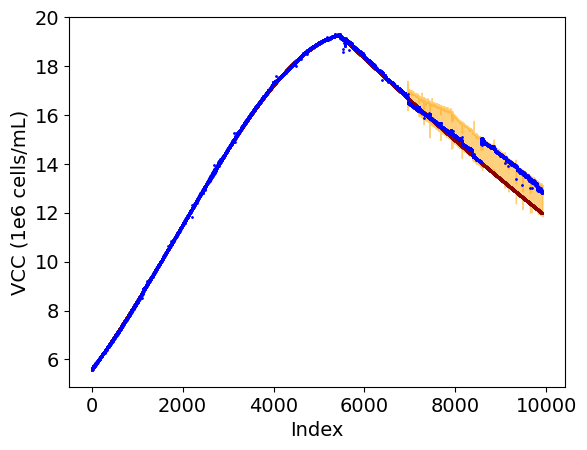


R2 Score:  0.7605013815670587

MSE:  0.447871280820609


In [33]:
"""Plotting"""

plt.xlabel("Index")
plt.ylabel("VCC (1e6 cells/mL)")


plt.rcParams.update({'font.size': 14})

plt.fill_between(test_index_shifted, LowerBound[:,0], UpperBound[:,0], color = 'orange', label = 'Prediction bands', alpha = 0.5)

#scatter plot of index vs glucose
plt.scatter(train_index, actuals[0:train_size], label='Actual values', color='darkred', s=1)
plt.scatter(train_index, train_predictions, label='Predictions', color='blue', s=1)

plt.scatter(test_index_shifted, actuals[train_size+1:len(X_df)], color='darkred', s=1)
plt.scatter(test_index_shifted, y_pred[:,0], color = 'blue', s=1)

#Visualisation

# legend = plt.legend()
# legend.legend_handles[0]._sizes = [50]
# legend.legend_handles[1]._sizes = [30]
plt.show()

from sklearn.metrics import mean_squared_error,  r2_score, mean_absolute_error

R2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print('\nR2 Score: ', R2)
print('\nMSE: ', MSE)

In [34]:
# Concatenating actuals
actuals_concat = actuals[train_size+1:len(X_df)]

# Calculating (Upperbound - Lowerbound)/actuals
cp_metric = ((UpperBound[:,0] - LowerBound[:,0]) / actuals_concat)*100

# Outputting minimum, maximum, and mean of the calculation
cp_metric_min = np.min(cp_metric)
cp_metric_max = np.max(cp_metric)
cp_metric_mean = np.mean(cp_metric)

print("Minimum of the calculation:", round(cp_metric_min,3))
print("Maximum of the calculation:", round(cp_metric_max,3))
print("Mean of the calculation:", round(cp_metric_mean,3))

Minimum of the calculation: 2.568
Maximum of the calculation: 10.45
Mean of the calculation: 7.121
